# <span style = 'color: red'>**Práctica uno.** Aprendizaje de máquina
# ***Regresión y clasificación***

- **Simón Cuartas Rendón**

En este *notebook* de Python se aborda la solución a los problemas de regresión y clasificación propuestos para la primera práctica del curso de **Aprendizaje de Máquina**.

A continuación, se abren los paquetes que se usarán tanto para los problemas de regresión como de clasificación.

**Importante.** Tanto para el problema de clasificación, como para el de regresión, se planteará un *pipeline* que permita automatizar el preprocesamiento de los datos, de tal forma que se puedan usar más adelante para cada uno de los modelos que se van a plantear.

In [24]:
#
# Apertura de paquetes genéricos
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

# Importación de matriz de confusión
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    cohen_kappa_score,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)

# <span style = 'color: green'>***1.***</span> Regresión

# <span style = 'color: green'>***2.***</span> Clasificación

Se utilizará el marco de datos `HeartDisease`. El objetivo será entrenar modelos que permitan identificar si una persona está en riesgo o no de padecer una enfermedad cardíaca. Para ello, primero se va a evaluar el marco de datos y se realizará un preprocesamiento inicial de las variables regresoras.

## <span style = 'color: cyan'>***2.1.***</span> Apertura del marco de datos y revisión inicial

In [2]:
#
# Apertura
direc_clasif = '../Datos/HeartDisease.csv'
hd = pd.read_csv(direc_clasif)

# Dimensión
hd.shape

(1190, 12)

In [3]:
#
# Vista de los primeros cinco registros
hd.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [6]:
#
# Información de los tipos de datos
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


Nótese que todas las variables se han cargado como si fuerna cuantitativas; sin embargo, esto no es correcto en la medida que algunas de las variables son categóricas (por ejemplo: `sex` y `class`). En la etapa del preprocesamiento se corregirá esto para poder aplicar los tratamientos adecuados a cada una de las variables según su tipología.

In [5]:
#
# Resumen numérico
hd.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,3.232773,132.153782,210.363866,0.213445,0.698319,139.732773,0.387395,0.922773,1.624370,0.528571
std,9.358203,0.424884,0.935480,18.368823,101.420489,0.409912,0.870359,25.517636,0.487360,1.086337,0.610459,0.499393
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,188.000000,0.000000,0.000000,121.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,229.000000,0.000000,0.000000,140.500000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,269.750000,0.000000,2.000000,160.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


Se evidencia que existen variables continuas con rangos o soportes diferentes. Por ejemplo, el campo `resting bp s` toma valores por el orden de los cientos, mientras que `oldpeak` tomas valores que son de apenas unas cuantas centenas. En este orden de ideas, es necesario llevar a cabo un proceso de **escalamiento** que evite que el modelo se sesgue.

In [12]:
#
# Verificación de valores nulos
hd.isna().any()

age                    False
sex                    False
chest pain type        False
resting bp s           False
cholesterol            False
fasting blood sugar    False
resting ecg            False
max heart rate         False
exercise angina        False
oldpeak                False
ST slope               False
target                 False
dtype: bool

Para ninguna de las columnas se cuentan con instancias nulas, por lo que se van a usar todos los datos para entrenar el modelo. Ahora, se revisará si el marco de datos está desbalanceado.

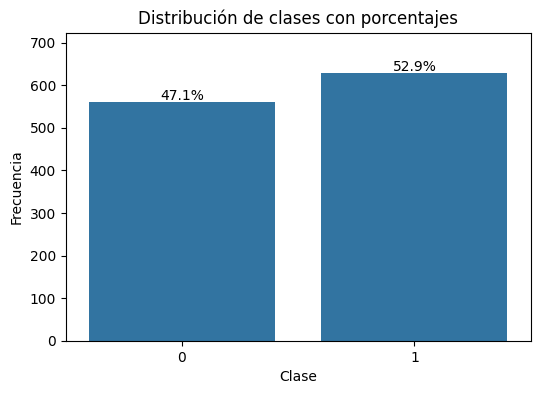

In [ ]:
#
# Calcular frecuencia absoluta y relativa
conteo_obj = hd['target'].value_counts().sort_index()
relativo = hd['target'].value_counts(normalize=True).sort_index() * 100

# Crear figura y ejes
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=conteo_obj.index, y=conteo_obj.values)

# Agregar etiquetas de porcentaje sobre las barras
for i, val in enumerate(relativo.values):
    ax.text(i, conteo_obj.values[i] + 5, f'{val:.1f}%', ha='center')

# Estética del gráfico
plt.title("Distribución de clases con porcentajes")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.ylim(top=max(conteo_obj.values)*1.15)
plt.show()

Si bien etiqueta asociada a personas con mayor chance de desarrollar problemas cardíacos es más frecuente, ambas etiquetas difieren por menos de un 6 %, por lo que no se puede decir que este marco de datos esté desbalanceado. Así, se trabajará con estos mismos datos.

## <span style = 'color: cyan'>***2.2.***</span> Preprocesamiento de los datos

A continución, se definirá una tubería o *pipeline* con la cual se puede abordar el preprocesamiento de los datos. Para la conversión de los tipos de datos, se tomarán a las variables nominales como categóricas.

In [13]:
#
# Cambio de tipología de datos para variables categóricas
cat_feats = ['sex', 'chest pain type', 'fasting blood sugar',
             'resting ecg', 'exercise angina', 'ST slope',
             'target']
hd[cat_feats] = hd[cat_feats].astype('category')

hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  1190 non-null   int64   
 1   sex                  1190 non-null   category
 2   chest pain type      1190 non-null   category
 3   resting bp s         1190 non-null   int64   
 4   cholesterol          1190 non-null   int64   
 5   fasting blood sugar  1190 non-null   category
 6   resting ecg          1190 non-null   category
 7   max heart rate       1190 non-null   int64   
 8   exercise angina      1190 non-null   category
 9   oldpeak              1190 non-null   float64 
 10  ST slope             1190 non-null   category
 11  target               1190 non-null   category
dtypes: category(7), float64(1), int64(4)
memory usage: 55.8 KB


In [15]:
#
# Matriz de diseño y variable objetivo
X_inic = hd.drop('target', axis=1)
y_inic = hd['target']

X_inic.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope
0,40,1,2,140,289,0,0,172,0,0.0,1
1,49,0,3,160,180,0,0,156,0,1.0,2
2,37,1,2,130,283,0,1,98,0,0.0,1
3,48,0,4,138,214,0,0,108,1,1.5,2
4,54,1,3,150,195,0,0,122,0,0.0,1


In [16]:
#
# Selección de variables continuas y categóricas
cont_feats = X_inic.select_dtypes(include=[np.number]).columns.tolist()
cat_feats = X_inic.select_dtypes(include=['category']).columns.tolist()

print(
    'Variables continuas:',
    cont_feats,
    '\nVariables categóricas:',
    cat_feats,
    sep = '\n'
)

Variables continuas:
['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']

Variables categóricas:
['sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope']


In [ ]:
#
# Transformaciones para las variables continuas
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ])

# Transformaciones para las variables categóricas
cat_pipe = Pipeline(steps=[
    ('onehot', OneHotEncoder(
        handle_unknown='ignore',
        drop='first')),
    ])

In [18]:
#
# Preprocesamiento
preprocesador = ColumnTransformer(
    transformers=[
        ('num', num_pipe, cont_feats),
        ('cat', cat_pipe, cat_feats)
    ],
    remainder='drop',
)

preprocesador

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [21]:
#
# Aplicación
X = preprocesador.fit_transform(X_inic)

# Conversión 
X_df = pd.DataFrame(X, columns=preprocesador.get_feature_names_out())
X_df.head()

,num__age,num__resting bp s,num__cholesterol,num__max heart rate,num__oldpeak,cat__sex_1,cat__chest pain type_2,cat__chest pain type_3,cat__chest pain type_4,cat__fasting blood sugar_1,cat__resting ecg_1,cat__resting ecg_2,cat__exercise angina_1,cat__ST slope_1,cat__ST slope_2,cat__ST slope_3
0,-1.466728,0.427328,0.775674,1.265039,-0.849792,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.504600,1.516587,-0.299512,0.637758,0.071119,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.787437,-0.117301,0.716489,-1.636136,-0.849792,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-0.611503,0.318402,0.035867,-1.244085,0.531575,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.029915,0.971958,-0.151550,-0.695214,-0.849792,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Con esto listo, se puede proceder con el entrenamiento de los modelos.

In [25]:
#
# Obtención de los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y_inic, test_size=0.25, random_state=42
)

## <span style = 'color: cyan'>***2.3.***</span> Clasificador de ***Bayes ingenuo***.

En este caso, se optimizará el parámetro de **suavizamiento**: `var_smoothing`. 

In [26]:
from sklearn.naive_bayes import GaussianNB

In [42]:
#
# Grilla de hiperparámetros
param_grid_nb = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

# Optimizador
grilla_nb = GridSearchCV(
    GaussianNB(),
    param_grid=param_grid_nb,
    scoring='accuracy',
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Ajuste del modelo
grilla_nb.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,estimator,GaussianNB()
,param_grid,{'var_smoothing': array([1.0000...00000000e-09])}
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,priors,None


In [43]:
#
# Extracción de los resultados de la optimización
result_nb = pd.DataFrame(grilla_nb.cv_results_)

# Extracción de parámetros y las exactitudes
var_smoothing_nb = result_nb['param_var_smoothing'].values
mean_test_score_nb = result_nb['mean_test_score'].values

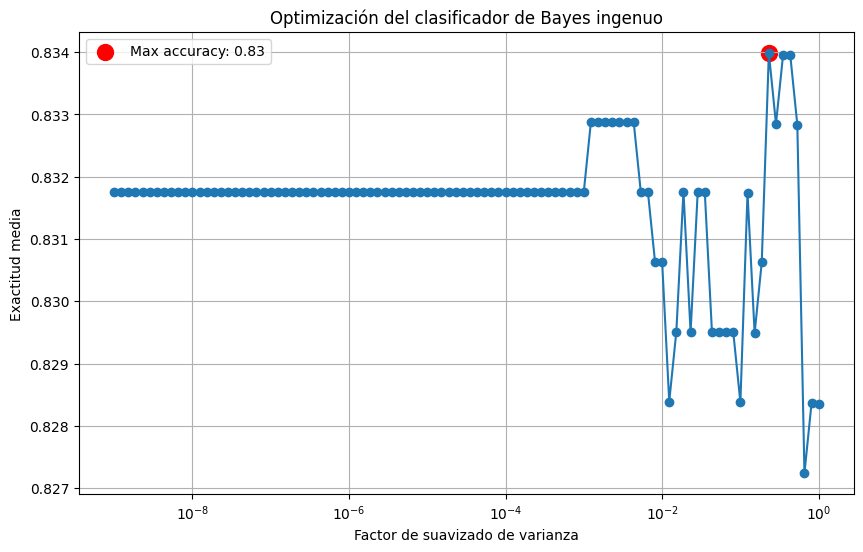

Mejor parámetro de suavizado de varianza: 0.23
Mejor exactitud: 0.83


In [55]:
#
# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(var_smoothing_nb, mean_test_score_nb, marker='o')
plt.xscale('log')
plt.xlabel('Factor de suavizado de varianza')
plt.ylabel('Exactitud media')
plt.title('Optimización del clasificador de Bayes ingenuo')

plt.scatter(
    var_smoothing_nb[np.argmax(mean_test_score_nb)],
    mean_test_score_nb.max(),
    color='red',
    s=120,              # tamaño más grande que los puntos normales
    edgecolors='red',
    linewidths=1.5,
    label=f'Max accuracy: {mean_test_score_nb.max():.2f}'
)

plt.legend()
plt.grid()
plt.show()

#
# Impresión de resultados
print(f"Mejor parámetro de suavizado de varianza: {grilla_nb.best_params_['var_smoothing']:.2f}")
print(f"Mejor exactitud: {grilla_nb.best_score_:.2f}")

In [71]:
#
# Mejor modelo
mejor_nb = grilla_nb.best_estimator_

In [87]:
def plot_confusion_and_roc(model, X_test, y_test, modelo=None, class_labels=None):

    # Predicciones
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # probabilidad clase positiva

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)

    # Curva ROC 
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    # Figura con subplots 
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Matriz de confusión
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Matriz de confusión')
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Real')

    # Curva ROC
    axes[1].plot(fpr, tpr, color='darkorange', label=f'AUC = {auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Tasa de falsos positivos (FPR)')
    axes[1].set_ylabel('Tasa de verdaderos positivos (TPR)')
    axes[1].set_title('Curva ROC')
    axes[1].legend(loc='lower right')

    fig.suptitle(f"Desempeño del modelo: {modelo}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    # Métricas de evaluación"
    print("MÉTRICAS DE EVALUACIÓN ")
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.2f}")
    print(f"Exactitud: {accuracy_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"Precisión: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=class_labels))

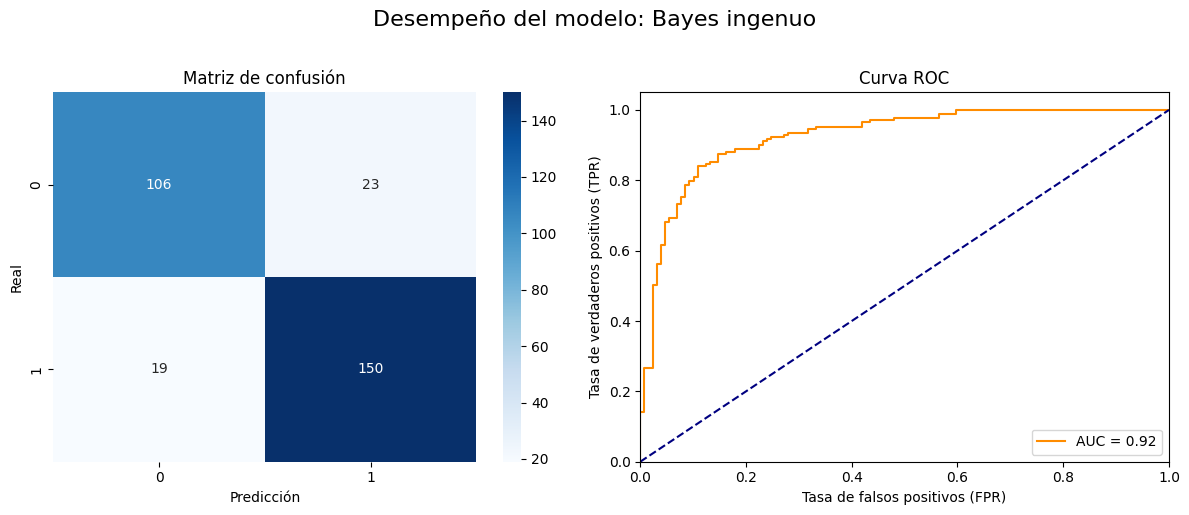

MÉTRICAS DE EVALUACIÓN 
Cohen's Kappa: 0.71
Exactitud: 0.86
F1 Score: 0.88
Precisión: 0.87
Recall: 0.89
ROC AUC: 0.85

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       129
           1       0.87      0.89      0.88       169

    accuracy                           0.86       298
   macro avg       0.86      0.85      0.86       298
weighted avg       0.86      0.86      0.86       298



In [86]:
plot_confusion_and_roc(mejor_nb, X_test, y_test, modelo='Bayes ingenuo',)

En general, se puede ver que el modelo de Bayes ingenuo tiene un desempeño adecuado, en la medida que la mayoría de etiquetas para ambos casos están siendo correctamente clasificados. Lo que es posible anticipar de esta matriz de confusión es que hay un mayor error en la predicción cuando no hay riesgo de problemas cardíacos, en la medida que hay una mayor cantidad de equivocaciones a pesar de que esta etiqueta tiene ligeramente menos instancias. Esto se puede validar con el reporte de clasificación, donde se que para las distintas métricas, estas son peores para tal etiqueta.